In [1]:
import dask.dataframe as dd
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots 
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
from math import sin, cos, sqrt, atan2, radians
# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files (x86)\\mingw-w64\\i686-8.1.0-posix-dwarf-rt_v6-rev0\\mingw32\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import gpxpy.geo
import folium
from pandas import Series
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import Imputer
# Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML, display

D:\anaconda\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
month=dd.read_csv('yellow_tripdata_2015-01.csv')

In [3]:
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

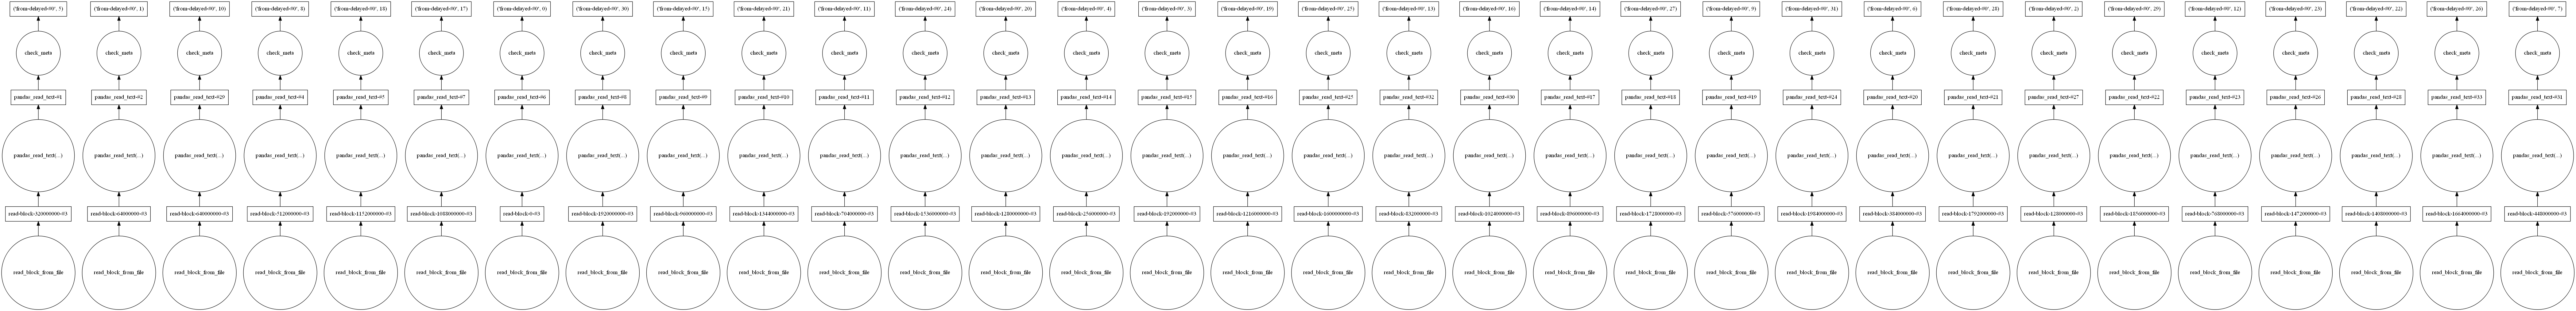

In [5]:
month.visualize()

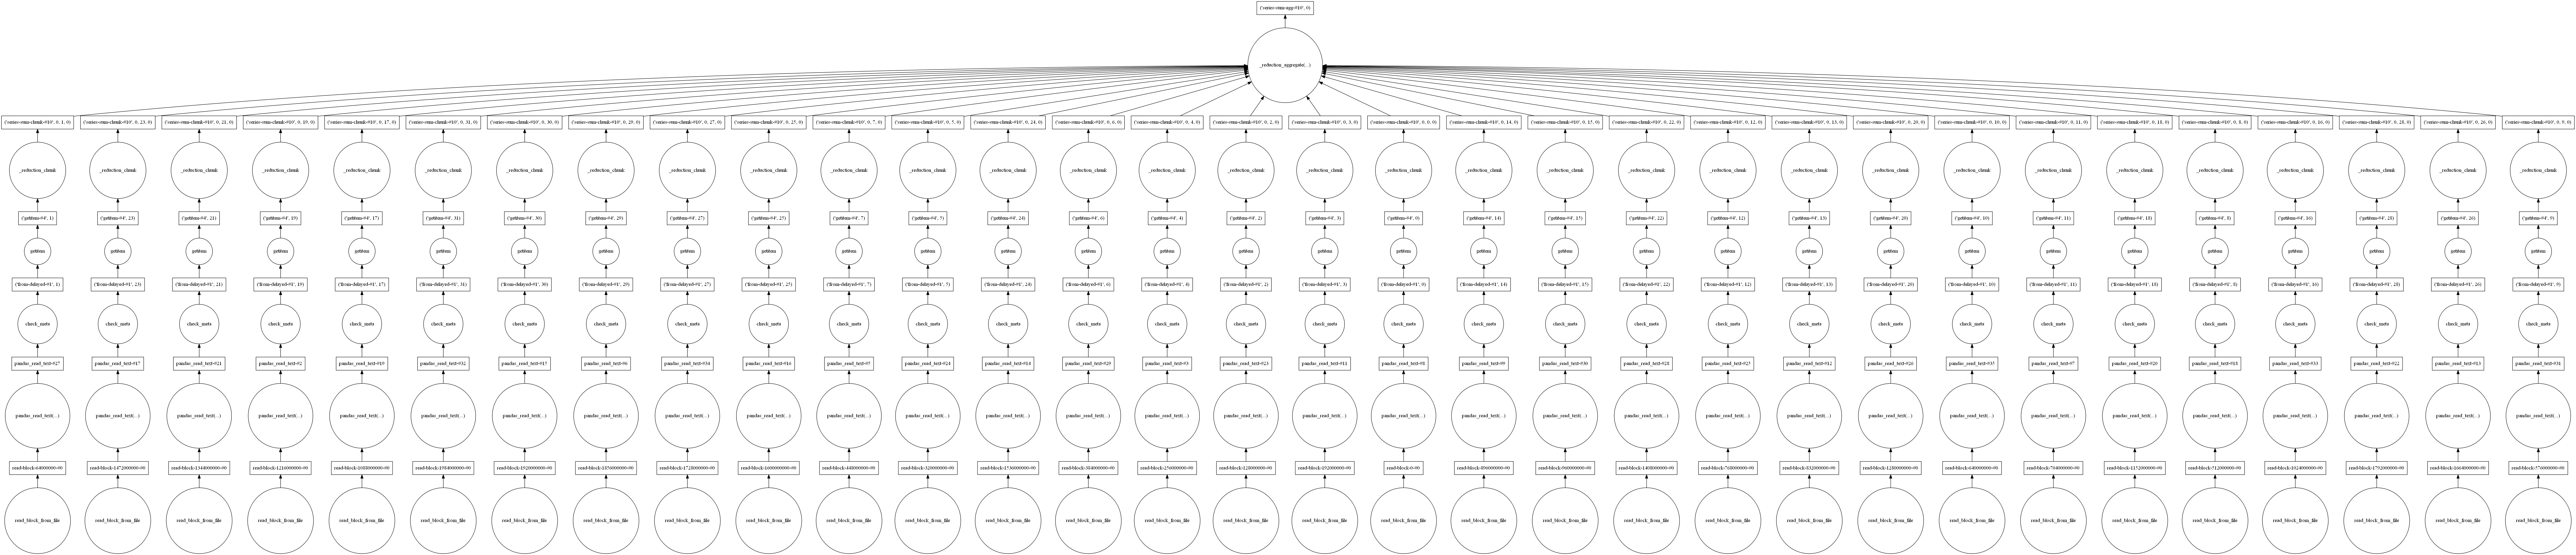

In [5]:
month.fare_amount.sum().visualize()

# Data Cleaning

In [219]:
month.head(5)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

# PickUp Latitude and PickUp Longitude

In [9]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
display(map_osm)

# Dropoff Longitude and DropOff Latitude

In [221]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]


map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

In [4]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s,"%Y-%m-%d %H:%M:%S").timetuple())

In [5]:
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup=[convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    return new_frame

In [6]:
frame_with_duration=return_with_trip_times(month)

In [7]:
frame_with_duration.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

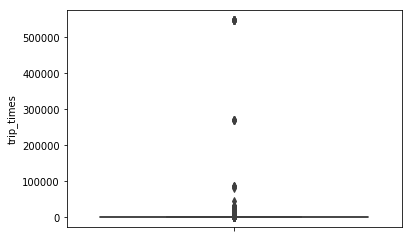

In [8]:
sns.boxplot(y='trip_times',data=frame_with_duration)
plt.show()

In [14]:
for i in range(0,100,10):
    var=frame_with_duration['trip_times'].values
    var=np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])    

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.633333


In [15]:
for i in range(90,100):
    var=frame_with_duration['trip_times'].values
    var=np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])    

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.633333


In [9]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_duration[(frame_with_duration.trip_times>1) & (frame_with_duration.trip_times<720)]

In [10]:
frame_with_durations_modified.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

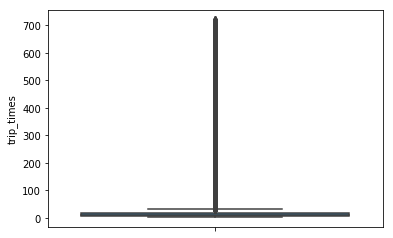

In [11]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

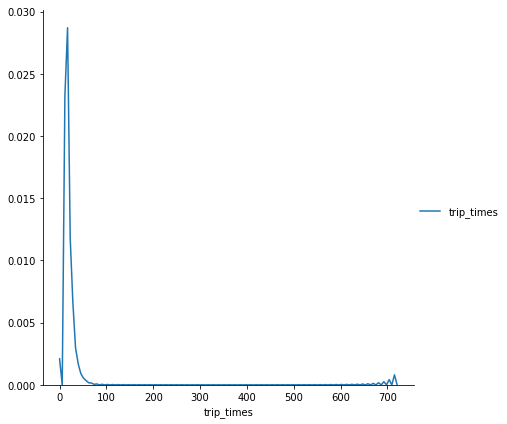

In [19]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [11]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

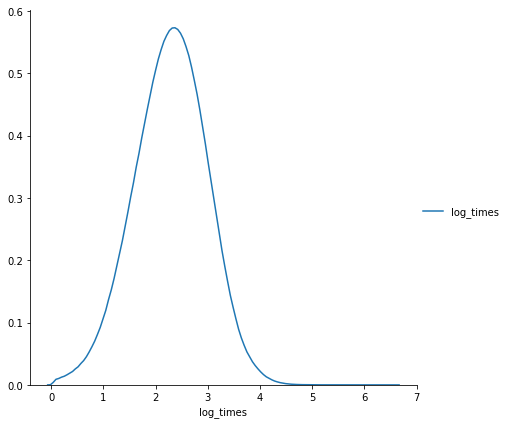

In [21]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

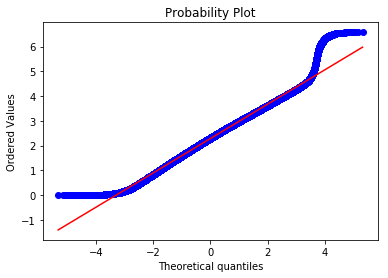

In [22]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

# Speed

In [12]:
frame_with_durations_modified['Speed']=60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])

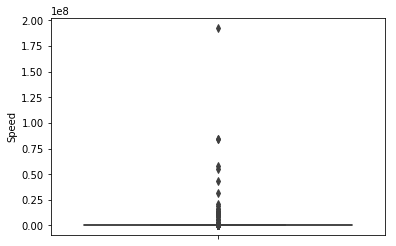

In [24]:
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [20]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.857


In [21]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.857


In [22]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.857


In [13]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_duration[(frame_with_duration.Speed>0) & (frame_with_duration.Speed<45.31)]

In [14]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

# Trip Distance

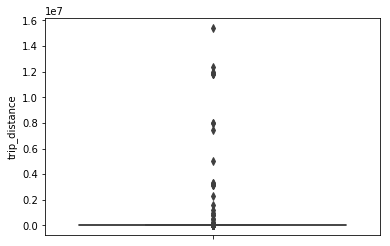

In [25]:
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [26]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [27]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [28]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [15]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_duration[(frame_with_duration.trip_distance>0) & (frame_with_duration.trip_distance<23)]

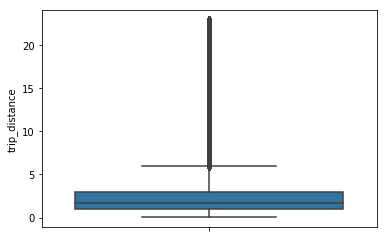

In [27]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# Total Fares

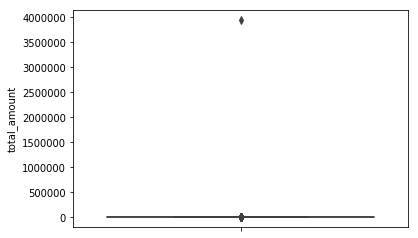

In [28]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [31]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [32]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [33]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


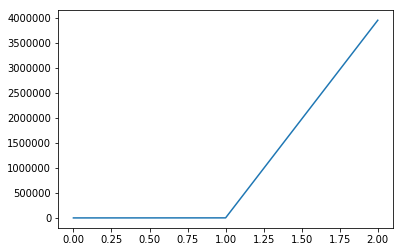

In [39]:
plt.plot(var[-3:])
plt.show()

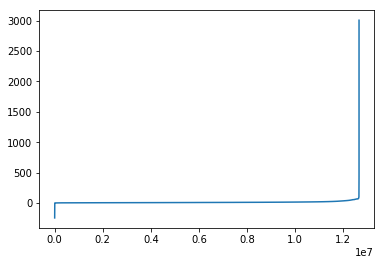

In [40]:
plt.plot(var[:-2])
plt.show()

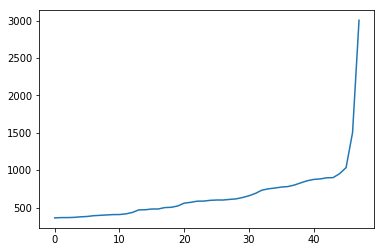

In [41]:
plt.plot(var[-50:-2])
plt.show()

# Remove All Outliers /Erronous Points

In [16]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [17]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_duration)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_duration))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


In [18]:
frame_with_durations_outliers_removed.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

In [19]:
frame_with_durations_outliers_removed['abs_lat_diff'] = (frame_with_durations_outliers_removed['dropoff_latitude'] - frame_with_durations_outliers_removed['pickup_latitude']).abs()
frame_with_durations_outliers_removed['abs_lon_diff'] = (frame_with_durations_outliers_removed['dropoff_longitude'] - frame_with_durations_outliers_removed['pickup_longitude']).abs()

In [20]:
frame_with_durations_outliers_removed.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  abs_lat_diff  abs_lon_diff  
0  1.421329e+09   5.285319      0.000507      0.019112  
1  1.420902e+09   9.983193      0.034866      0.007233  
2  1.420902e+09  10.746269      0.021626      0.011520  
3  1.420902e+09  16.071429      0.006168      0.004761  
4  1.420902e+09   9.318378      0.019775      0.033005

# Data Preparation and Segmentation

In [21]:
coords=frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values

In [202]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142543 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007387813 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172206 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

In [22]:
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

# plotting the cluster centers

In [22]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

# Plotting the clusters

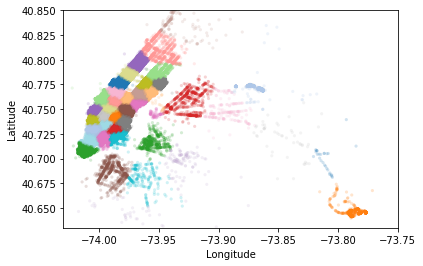

In [24]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

In [23]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [25]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [26]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  abs_lat_diff  abs_lon_diff  pickup_cluster  \
0  1.421329e+09   5.285319      0.000507      0.019112              34   
1  1.420902e+09   9.983193      0.034866      0.007233               2   
2  1.420902e+09  10.746269      0.021626      0.011520              16   
3  1.420902e+09  16.071429      0.006168      0.004761              38   
4  1.420902e+09   9.318378      0.019775      0.033005              22   

   pickup_bins  
0         2130  
1         1419  
2         1419  
3         1419  
4         1419

In [27]:
jan_2015_groupby.head(5)

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

In [28]:
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance',]].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame

In [29]:
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

In [30]:
month_jan_2016['abs_lat_diff'] = (month_jan_2016['dropoff_latitude'] - month_jan_2016['pickup_latitude']).abs()
month_jan_2016['abs_lon_diff'] = (month_jan_2016['dropoff_longitude'] - month_jan_2016['pickup_longitude']).abs()
month_feb_2016['abs_lat_diff'] = (month_feb_2016['dropoff_latitude'] - month_feb_2016['pickup_latitude']).abs()
month_feb_2016['abs_lon_diff'] = (month_feb_2016['dropoff_longitude'] - month_feb_2016['pickup_longitude']).abs()
month_mar_2016['abs_lat_diff'] = (month_mar_2016['dropoff_latitude'] - month_mar_2016['pickup_latitude']).abs()
month_mar_2016['abs_lon_diff'] = (month_mar_2016['dropoff_longitude'] - month_mar_2016['pickup_longitude']).abs()

In [31]:
jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

# Smoothing

In [32]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [33]:
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [255]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  1986
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  154
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
---------

In [37]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [38]:

def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [39]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [40]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  178560


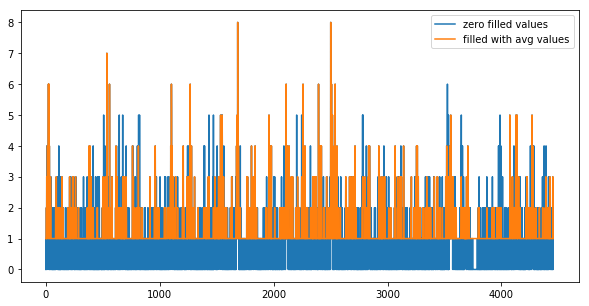

In [46]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [41]:
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

In [42]:
regions_cum = []
for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])


# Time Series and Fourier Transform

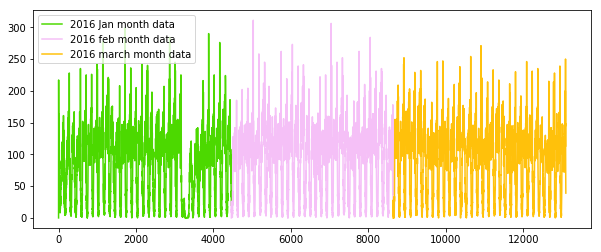

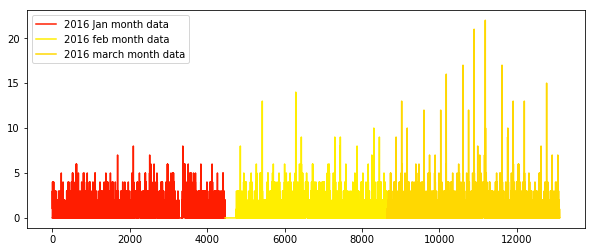

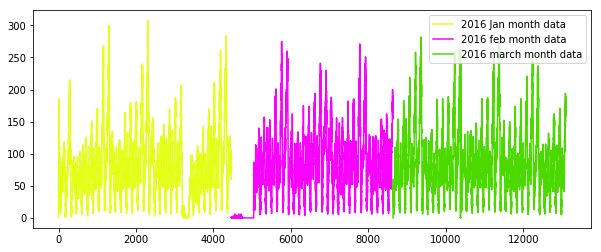

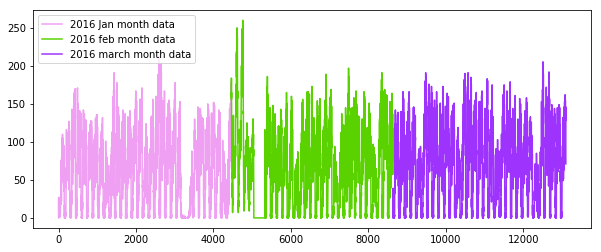

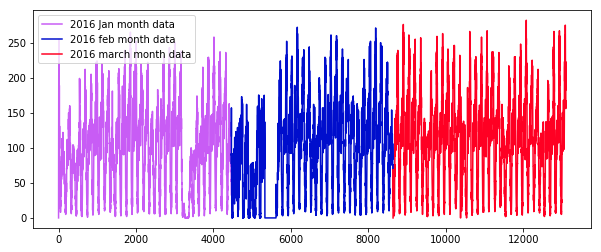

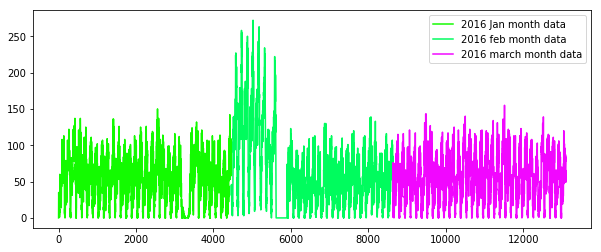

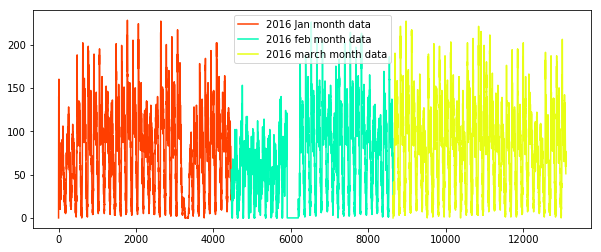

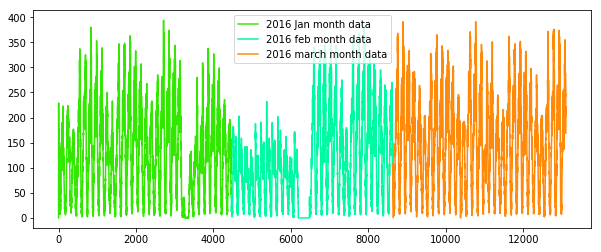

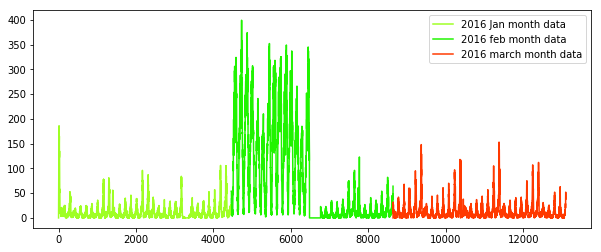

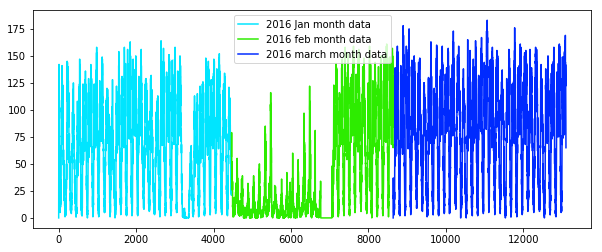

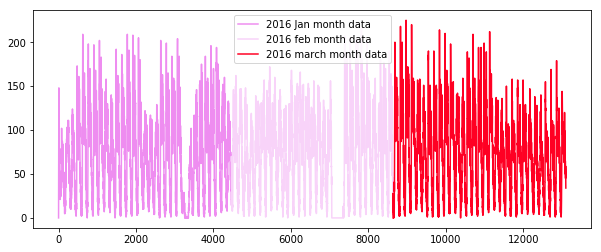

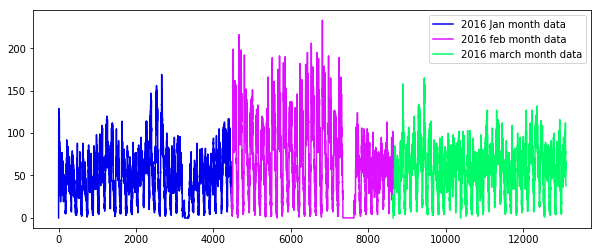

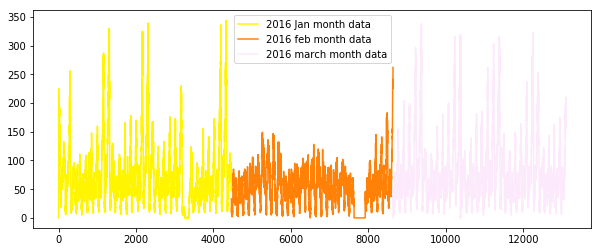

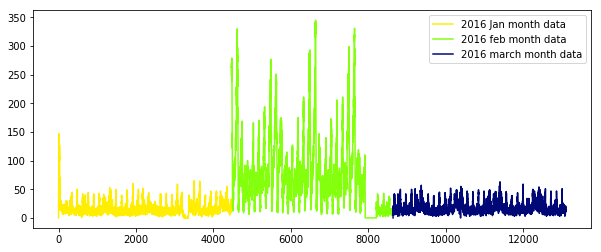

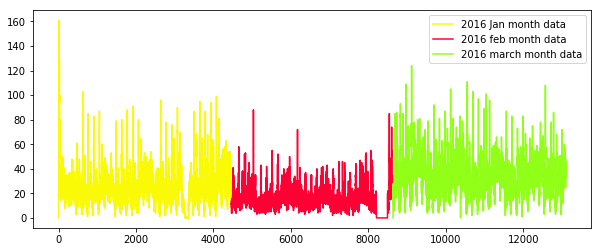

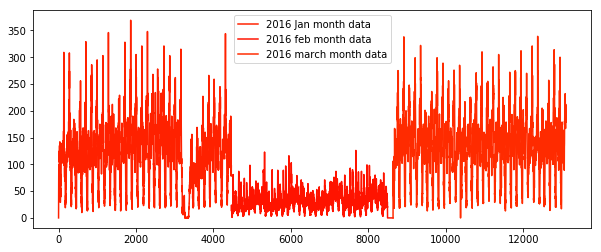

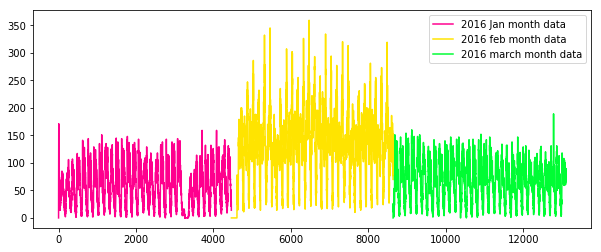

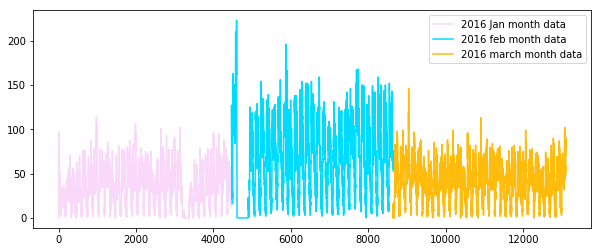

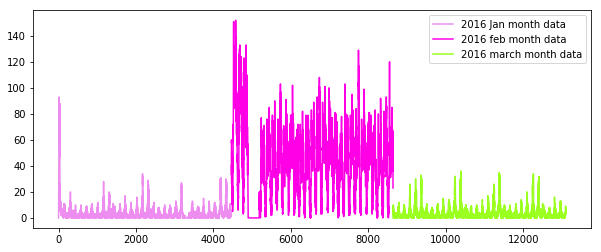

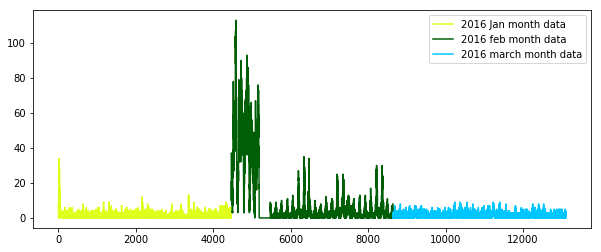

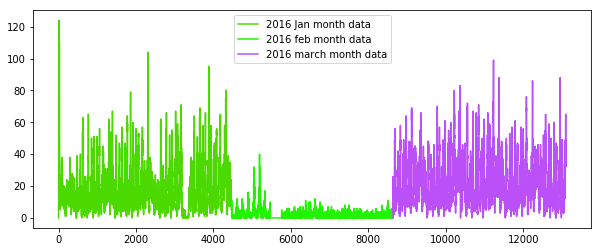

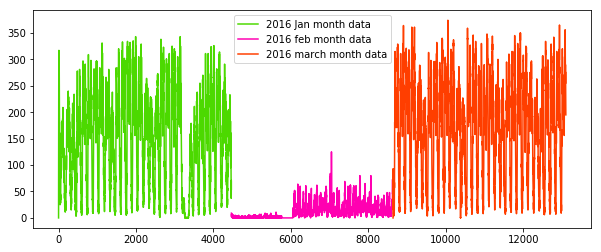

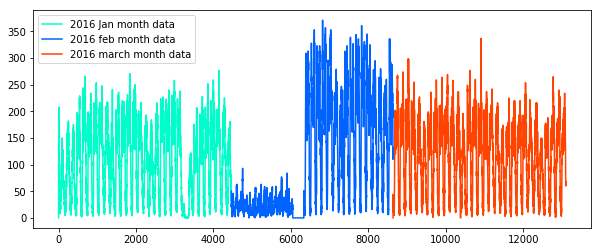

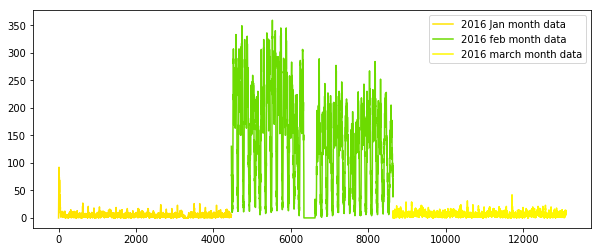

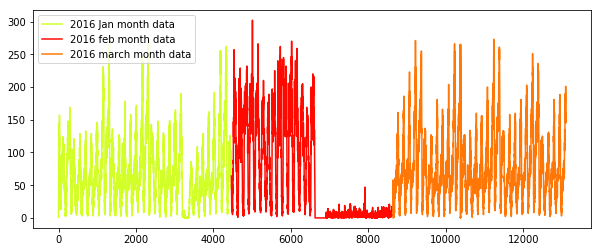

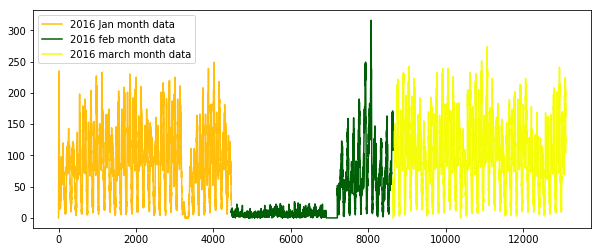

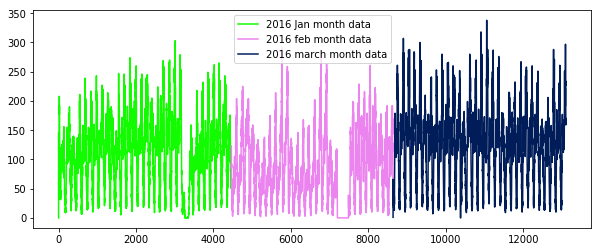

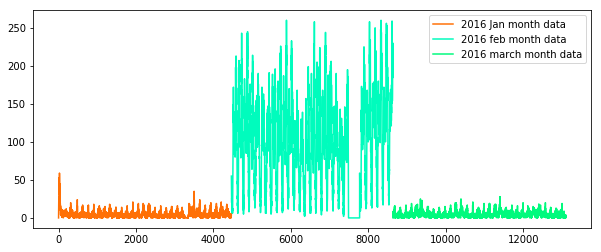

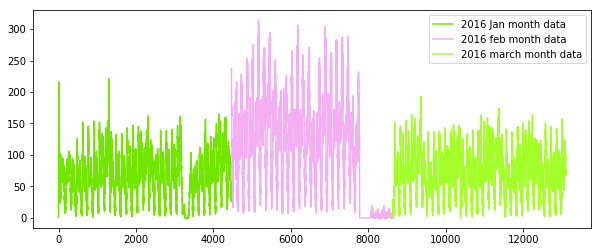

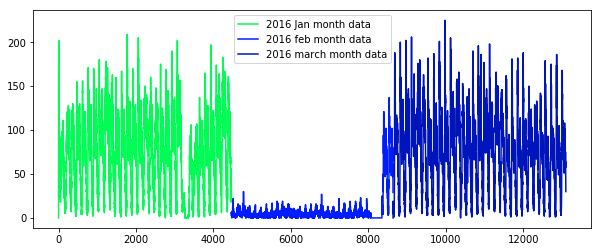

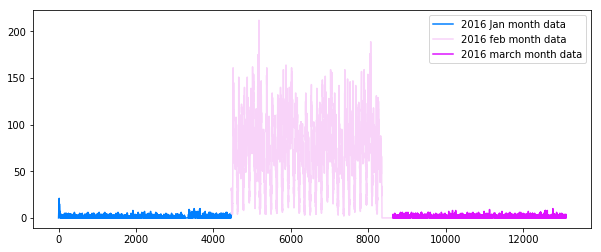

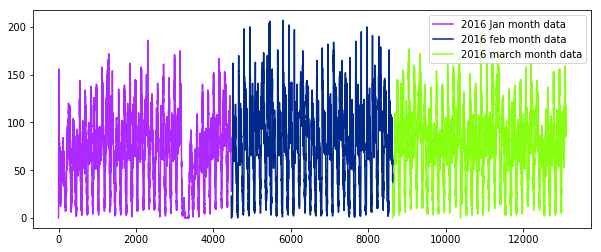

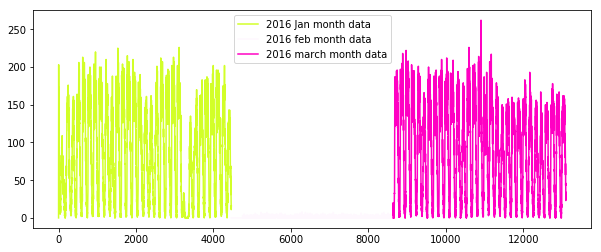

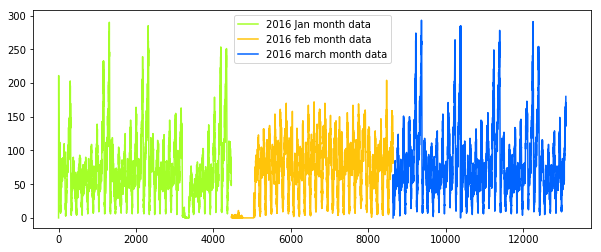

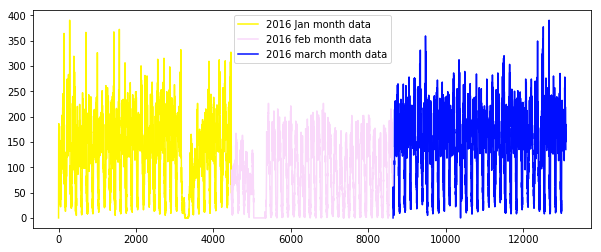

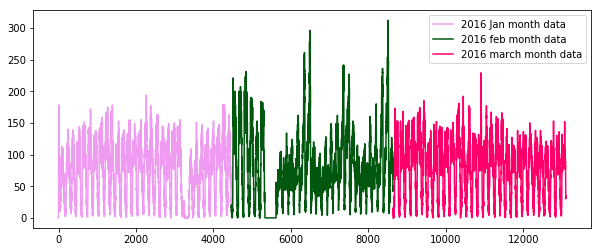

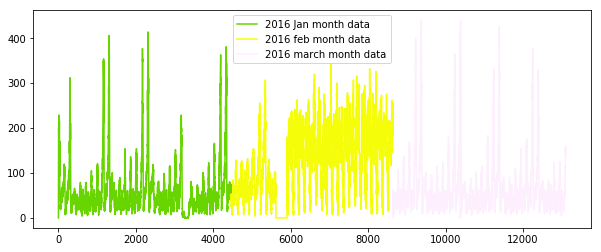

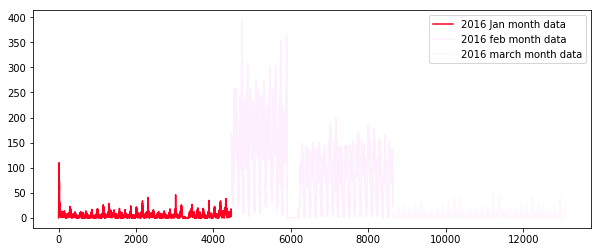

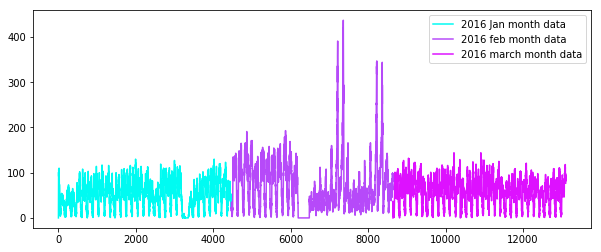

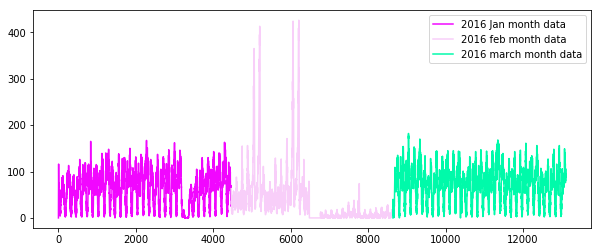

In [43]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

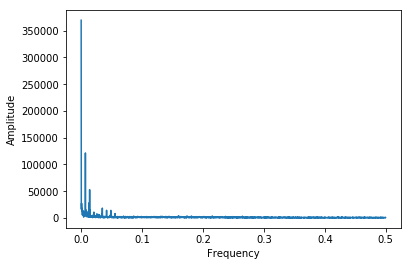

In [221]:
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [44]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [45]:
ratios_jan.head()

Given  Prediction    Ratios
0     53           0  0.000000
1     53          63  1.188679
2    199         217  1.090452
3    208         189  0.908654
4    141         137  0.971631

In [46]:
x=(ratios_jan['Ratios'].values)[0]
error=[]
predicted_values=[]
window_size=3
predicted_ratio_values=[]


# Simple Moving Average

In [47]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [48]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

# Weighted Moving Average

In [49]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [50]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

# Exponential Weighted Average

In [51]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [52]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [53]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

# Comparison between Baseline Model

In [50]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.182115517339       MSE:  400.0625504032258
Moving Averages (2016 Values) -                        MAPE:  0.14292849687        MSE:  174.84901993727598
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.178486925438       MSE:  384.01578741039424
Weighted Moving Averages (2016 Values) -               MAPE:  0.135510884362       MSE:  162.46707549283155
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.177835501949       MSE:  378.34610215053766
Exponential Moving Averages (2016 Values) -         MAPE:  0.135091526367       MSE:  159.7361

# Regression Model

In [54]:
number_of_time_stamps =5
output=[]
tsne_lat=[]
tsne_lon=[]
tsne_weekday=[]
tsne_feature=[]
tsne_feature=[0]*number_of_time_stamps

In [55]:
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [56]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [57]:
alpha=0.3
predicted_values=[]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [58]:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [59]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [60]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [61]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [62]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [63]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [64]:
tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [65]:

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [66]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [67]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [96]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0   118   106   104    93   102  40.776228 -73.982119        4      100
1   106   104    93   102   101  40.776228 -73.982119        4      100
2   104    93   102   101   120  40.776228 -73.982119        4      114
3    93   102   101   120   131  40.776228 -73.982119        4      125
4   102   101   120   131   164  40.776228 -73.982119        4      152

# Using Linear Regression

In [253]:
from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

# Using Random Forest Regressor

In [245]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [246]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [88]:
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[ 0.04594004  0.04413003  0.14429377  0.11789905  0.30512402  0.00597832
  0.00254913  0.00164174  0.33244389]


# Using XGBoostRegressor

In [250]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [251]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

# Hyperparameter tunning of the SGDRegressor using GridSearchCV

In [279]:
parma_grid={'alpha':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty':['l1','l2']}
sgd_regressor=SGDRegressor()
grid_sgd=GridSearchCV(estimator=sgd_regressor,param_grid=parma_grid)
grid_sgd.fit(df_train,tsne_train_output)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [280]:
grid_sgd.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [72]:
sgd=SGDRegressor(alpha=0.01,penalty='l2',eta0=0.000001,max_iter=100000)
sgd_reg=sgd.fit(df_train,tsne_train_output)
y_pred_sgd = sgd_reg.predict(df_test)
sgd_test_predictions = [round(value) for value in y_pred_sgd]
y_pred_sgd_train = sgd_reg.predict(df_train)
sgd_train_predictions = [round(value) for value in y_pred_sgd_train]

In [73]:
(mean_absolute_error(tsne_test_output,sgd_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output))

0.12923880591309267

# Hyperparameter tunning of the RandomForestRegressor using RandomSearchCV

In [ ]:
max_depths = np.linspace(1,64,2, endpoint=True)
n_estimators = [100,200,400,500,600,700,800,1000]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
parma_grids={'max_depth':max_depths,'n_estimators':n_estimators,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}
rf_regression=RandomForestRegressor()
random=RandomizedSearchCV(estimator=rf_regression,param_distributions=parma_grids,cv=5,n_iter=100,random_state=42)
random.fit(df_train,tsne_train_output)

In [312]:
random.best_params_

{'max_depth': 32.0, 'n_estimators': 200}

In [75]:
rf_regressor_1=RandomForestRegressor(n_estimators=200,max_depth=32)
random_forest=rf_regressor_1.fit(df_train,tsne_train_output)

In [77]:
y_pred_random_forest = random_forest.predict(df_test)
random_forest_test_predictions = [round(value) for value in y_pred_random_forest]
y_pred_random_forest_train = random_forest.predict(df_train)
random_forest__train_predictions = [round(value) for value in y_pred_random_forest_train]

In [78]:
(mean_absolute_error(tsne_test_output,random_forest_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output))

0.12850396996815613

# Hyperparameter tunning of the Xgboost using RandomSearchCV

In [98]:
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13]
n_estimators = [40, 80, 150,300,400,500,600]
parma_grids={'max_depth':max_depths,'n_estimators':n_estimators}

In [ ]:
xgb_regressor=xgb.XGBRegressor()
random_xgb=GridSearchCV(estimator=xgb_regressor,param_grid=parma_grids,cv=3)
random_xgb.fit(df_train_2,tsne_train_output)

In [87]:
random_xgb.best_params_

{'max_depth': 4, 'n_estimators': 80}

In [94]:
xgb_regressor=xgb.XGBRegressor(max_depth=10,n_estimators=80)
xgboost_reg=xgb_regressor.fit(df_train_2,tsne_train_output)

In [95]:
y_pred_xgboost = xgboost_reg.predict(df_test_2)
xgboost_test_predictions = [round(value) for value in y_pred_xgboost]
y_pred_xgboost_train = xgboost_reg.predict(df_train_2)
xgboost__train_predictions = [round(value) for value in y_pred_xgboost_train]

In [96]:
(mean_absolute_error(tsne_test_output,xgboost_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output))

0.12522497123349988

In [97]:
df_train_2.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0     0    63   217   189   137  40.776228 -73.982119        4      150   
1    63   217   189   137   135  40.776228 -73.982119        4      139   
2   217   189   137   135   129  40.776228 -73.982119        4      132   
3   189   137   135   129   150  40.776228 -73.982119        4      144   
4   137   135   129   150   164  40.776228 -73.982119        4      158   

      freq1    freq2     freq3     freq4     freq5          Amp1  \
0  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
1  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
2  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
3  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
4  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   

           Amp2          Amp3          Amp4          Amp5  
0  65993.385455  50148.386133  29018.427417  24693.247765  
1  65993.385455  50148.386133  29018.427417  24693.247765  
2  65993.385455  50148.386133  29018.427417  24693.247765  
3  65993.385455  50148.386133  29018.427417  24693.247765  
4  65993.385455  50148.386133  29018.427417  24693.247765

In [269]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,sgd_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output,sgd_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [270]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("Xgboost regressor-                          Train: ",train_mape[3],"     Test: ",test_mape[3])
print (" SGDregressor-                              Train: ",train_mape[5],"     Test: ",test_mape[5])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.140052758787       Test:  0.136531257048
Exponential Averages Forecasting -           Train:  0.13289968436       Test:  0.129361804204
Linear Regression -                         Train:  0.13331572016       Test:  0.129120299401
Random Forest Regression -                   Train:  0.0918418435846      Test:  0.12724751423
Xgboost regressor-                          Train:  0.129406385358      Test:  0.126866668705
 SGDregressor-                              Train:  0.131703476084      Test:  0.127589653999


# Picking up the first Five highest amplitude and Frequency as features

In [98]:
amplitude_lists = []
frequency_lists = []
for i in range(40):
    ampli=np.abs(np.fft.fft(regions_cum[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:] 
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(13099):
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values)

In [99]:
train_fourier_frequencies = [frequency_lists[i*13099:(13099*i+9169)] for i in range(0,40)]
test_fourier_frequencies = [frequency_lists[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [100]:
train_fourier_amplitudes = [amplitude_lists[i*13099:(13099*i+9169)] for i in range(0,40)]
test_fourier_amplitudes = [amplitude_lists[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [101]:
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(40):
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [102]:
train_prev_freq_amp = np.hstack((train_freq, train_amp))
test_prev_freq_amp = np.hstack((test_freq, test_amp))

In [103]:
columns=['freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
train_feature_new=pd.DataFrame(train_prev_freq_amp,columns=columns)
test_feature_new=pd.DataFrame(test_prev_freq_amp,columns=columns)

In [104]:
df_train_1=pd.concat([df_train,train_feature_new],axis=1)

In [105]:
df_test_1=pd.concat([df_test,test_feature_new],axis=1)

In [106]:
df_train_1.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0     0    63   217   189   137  40.776228 -73.982119        4      150   
1    63   217   189   137   135  40.776228 -73.982119        4      139   
2   217   189   137   135   129  40.776228 -73.982119        4      132   
3   189   137   135   129   150  40.776228 -73.982119        4      144   
4   137   135   129   150   164  40.776228 -73.982119        4      158   

      freq1    freq2     freq3     freq4     freq5          Amp1  \
0  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
1  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
2  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
3  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
4  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   

           Amp2          Amp3          Amp4          Amp5  
0  65993.385455  50148.386133  29018.427417  24693.247765  
1  65993.385455  50148.386133  29018.427417  24693.247765  
2  65993.385455  50148.386133  29018.427417  24693.247765  
3  65993.385455  50148.386133  29018.427417  24693.247765  
4  65993.385455  50148.386133  29018.427417  24693.247765

In [107]:
df_test_1.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0   118   106   104    93   102  40.776228 -73.982119        4      100   
1   106   104    93   102   101  40.776228 -73.982119        4      100   
2   104    93   102   101   120  40.776228 -73.982119        4      114   
3    93   102   101   120   131  40.776228 -73.982119        4      125   
4   102   101   120   131   164  40.776228 -73.982119        4      152   

      freq1    freq2     freq3     freq4     freq5          Amp1  \
0  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
1  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
2  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
3  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   
4  0.006836  0.00708  0.013916  0.012939  0.007812  79801.690695   

           Amp2          Amp3          Amp4          Amp5  
0  65993.385455  50148.386133  29018.427417  24693.247765  
1  65993.385455  50148.386133  29018.427417  24693.247765  
2  65993.385455  50148.386133  29018.427417  24693.247765  
3  65993.385455  50148.386133  29018.427417  24693.247765  
4  65993.385455  50148.386133  29018.427417  24693.247765

In [118]:
scaler_1=StandardScaler()
train=scaler_1.fit_transform(df_train_1.values)
test=scaler_1.transform(df_test_1.values)

In [121]:
col=['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'freq1', 'freq2', 'freq3', 'freq4', 'freq5', 'Amp1', 'Amp2',
       'Amp3', 'Amp4', 'Amp5']
df_train_st=pd.DataFrame(train,columns=col)
df_test_st=pd.DataFrame(test,columns=col)

In [122]:
df_train_st.head()

ft_5      ft_4      ft_3      ft_2      ft_1       lat       lon  \
0 -0.977232  0.024184  2.472368  2.027398  1.200848  0.840789 -0.438156   
1  0.024313  2.472428  2.027239  1.200688  1.169049  0.840789 -0.438156   
2  2.472536  2.027293  1.200571  1.168891  1.073652  0.840789 -0.438156   
3  2.027404  1.200613  1.168776  1.073502  1.407540  0.840789 -0.438156   
4  1.200732  1.168818  1.073391  1.407365  1.630131  0.840789 -0.438156   

    weekday   exp_avg     freq1     freq2     freq3     freq4     freq5  \
0  0.496692  1.427357 -0.342404 -0.147479  0.631078  0.637831 -0.025878   
1  0.496692  1.251228 -0.342404 -0.147479  0.631078  0.637831 -0.025878   
2  0.496692  1.139146 -0.342404 -0.147479  0.631078  0.637831 -0.025878   
3  0.496692  1.331286 -0.342404 -0.147479  0.631078  0.637831 -0.025878   
4  0.496692  1.555450 -0.342404 -0.147479  0.631078  0.637831 -0.025878   

       Amp1      Amp2     Amp3      Amp4      Amp5  
0  0.799214  0.747036  0.65218  0.133467  0.116093  
1  0.799214  0.747036  0.65218  0.133467  0.116093  
2  0.799214  0.747036  0.65218  0.133467  0.116093  
3  0.799214  0.747036  0.65218  0.133467  0.116093  
4  0.799214  0.747036  0.65218  0.133467  0.116093

In [108]:
train_df=pd.DataFrame(train_new_features)
test_df=pd.DataFrame(test_new_features)

In [109]:
train_df.shape

(366760, 5)

# Incorporating Some windows features

In [110]:
width=6
lag_1=train_df.shift(width-1)
window=lag_1.rolling(window=width)
#diff=window.max() - window.min()
dataframe_train=pd.concat([window.min(),window.max(),window.median(),window.var(),window.sum(),window.count()],axis=1)

In [111]:
lag_1=test_df.shift(width-1)
window=lag_1.rolling(window=width)
#diff=window.max() - window.min()
dataframe_test=pd.concat([window.min(),window.max(),window.median(),window.var(),window.sum(),window.count()],axis=1)

In [112]:
imputer=Imputer()
trans_dataframe_train=imputer.fit_transform(dataframe_train)
trans_dataframe_test=imputer.transform(dataframe_test)

In [85]:
std=StandardScaler()
trans_dataframe_train_std=std.fit_transform(trans_dataframe_train)

In [86]:
trans_dataframe_test_std=std.transform(trans_dataframe_test)

In [87]:
columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24','f25','f26','f27','f28','f29','f30']#,'f36','f37','f38','f39','f40']

In [88]:
df_train_2=pd.DataFrame(trans_dataframe_train_std,columns=columns)
df_test_2=pd.DataFrame(trans_dataframe_test_std,columns=columns)

In [89]:
df_train_2.head()

f1   f2            f3   f4   f5   f6   f7   f8   f9  f10     ...      f21  \
0  0.0  0.0  1.295250e-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0     ...      0.0   
1  0.0  0.0  1.295250e-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0     ...      0.0   
2  0.0  0.0  1.295250e-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0     ...      0.0   
3  0.0  0.0  1.295250e-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0     ...      0.0   
4  0.0  0.0  1.295250e-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0     ...      0.0   

            f22  f23  f24  f25         f26         f27         f28  \
0  1.529836e-16  0.0  0.0  0.0 -237.030658 -237.030658 -237.030658   
1  1.529836e-16  0.0  0.0  0.0 -237.030658 -237.030658 -237.030658   
2  1.529836e-16  0.0  0.0  0.0 -237.030658 -237.030658 -237.030658   
3  1.529836e-16  0.0  0.0  0.0 -237.030658 -237.030658 -237.030658   
4  1.529836e-16  0.0  0.0  0.0 -237.030658 -237.030658 -237.030658   

          f29         f30  
0 -237.030658 -237.030658  
1 -237.030658 -237.030658  
2 -237.030658 -237.030658  
3 -237.030658 -237.030658  
4 -237.030658 -237.030658  

[5 rows x 30 columns]

In [123]:
df_train_3=pd.concat([df_train_st,df_train_2],axis=1)
df_test_3=pd.concat([df_test_st,df_test_2],axis=1)

In [124]:
df_train_3.head()

ft_5      ft_4      ft_3      ft_2      ft_1       lat       lon  \
0 -0.977232  0.024184  2.472368  2.027398  1.200848  0.840789 -0.438156   
1  0.024313  2.472428  2.027239  1.200688  1.169049  0.840789 -0.438156   
2  2.472536  2.027293  1.200571  1.168891  1.073652  0.840789 -0.438156   
3  2.027404  1.200613  1.168776  1.073502  1.407540  0.840789 -0.438156   
4  1.200732  1.168818  1.073391  1.407365  1.630131  0.840789 -0.438156   

    weekday   exp_avg     freq1     ...      f21           f22  f23  f24  f25  \
0  0.496692  1.427357 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
1  0.496692  1.251228 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
2  0.496692  1.139146 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
3  0.496692  1.331286 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
4  0.496692  1.555450 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   

          f26         f27         f28         f29         f30  
0 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
1 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
2 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
3 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
4 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  

[5 rows x 49 columns]

In [125]:
df_test_3.head()

ft_5      ft_4      ft_3      ft_2      ft_1       lat       lon  \
0  0.898679  0.707785  0.675954  0.501164  0.644369  0.840789 -0.438156   
1  0.707908  0.675989  0.501082  0.644248  0.628470  0.840789 -0.438156   
2  0.676113  0.501115  0.644159  0.628350  0.930558  0.840789 -0.438156   
3  0.501240  0.644194  0.628262  0.930417  1.105451  0.840789 -0.438156   
4  0.644318  0.628296  0.930314  1.105298  1.630131  0.840789 -0.438156   

    weekday   exp_avg     freq1     ...      f21           f22  f23  f24  f25  \
0  0.496692  0.626772 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
1  0.496692  0.626772 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
2  0.496692  0.850936 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
3  0.496692  1.027064 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   
4  0.496692  1.459380 -0.342404     ...      0.0  1.529836e-16  0.0  0.0  0.0   

          f26         f27         f28         f29         f30  
0 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
1 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
2 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
3 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  
4 -237.030658 -237.030658 -237.030658 -237.030658 -237.030658  

[5 rows x 49 columns]

In [167]:
from sklearn.decomposition import PCA
coords_1=df_train_3[['lat','lon']]
pca=PCA().fit(coords_1)
df_train_3['pickup_pca0'] =pca.transform(df_train_3[['lat','lon']])[:,0]
df_train_3['pickup_pca1'] =pca.transform(df_train_3[['lat','lon']])[:,1]
df_test_3['pickup_pca0'] =pca.transform(df_test_3[['lat','lon']])[:,0]
df_test_3['pickup_pca1'] =pca.transform(df_test_3[['lat','lon']])[:,1]

# Applying XGBoost while incoporating some of the new features , 

In [169]:
params = {
   
    'max_depth':16,
    'gamma' :0.2,
    'eta':.01, 
    'subsample': 0.8,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0,
    'n_estimators':250,
    'lambda':5,
    'min_child_weight':5
}

In [143]:
df_train_3.head()

ft_5      ft_4      ft_3      ft_2      ft_1       lat       lon  \
0 -0.977232  0.024184  2.472368  2.027398  1.200848  0.840789 -0.438156   
1  0.024313  2.472428  2.027239  1.200688  1.169049  0.840789 -0.438156   
2  2.472536  2.027293  1.200571  1.168891  1.073652  0.840789 -0.438156   
3  2.027404  1.200613  1.168776  1.073502  1.407540  0.840789 -0.438156   
4  1.200732  1.168818  1.073391  1.407365  1.630131  0.840789 -0.438156   

    weekday   exp_avg     freq1     ...       f23  f24  f25         f26  \
0  0.496692  1.427357 -0.342404     ...       0.0  0.0  0.0 -237.030658   
1  0.496692  1.251228 -0.342404     ...       0.0  0.0  0.0 -237.030658   
2  0.496692  1.139146 -0.342404     ...       0.0  0.0  0.0 -237.030658   
3  0.496692  1.331286 -0.342404     ...       0.0  0.0  0.0 -237.030658   
4  0.496692  1.555450 -0.342404     ...       0.0  0.0  0.0 -237.030658   

          f27         f28         f29         f30  pickup_pca0  pickup_pca1  
0 -237.030658 -237.030658 -237.030658 -237.030658     -0.90435    -0.284704  
1 -237.030658 -237.030658 -237.030658 -237.030658     -0.90435    -0.284704  
2 -237.030658 -237.030658 -237.030658 -237.030658     -0.90435    -0.284704  
3 -237.030658 -237.030658 -237.030658 -237.030658     -0.90435    -0.284704  
4 -237.030658 -237.030658 -237.030658 -237.030658     -0.90435    -0.284704  

[5 rows x 51 columns]

In [163]:
matrix_train=xgb.DMatrix(df_train_3,label=tsne_train_output)
matrix_test = xgb.DMatrix(df_test_3,label=tsne_test_output)
model=xgb.train(params=params,dtrain=matrix_train,num_boost_round=5000,early_stopping_rounds=10,evals=[(matrix_test,'test')])

[0]	test-rmse:90.8854
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:89.9986
[2]	test-rmse:89.1207
[3]	test-rmse:88.2521
[4]	test-rmse:87.392
[5]	test-rmse:86.5407
[6]	test-rmse:85.6985
[7]	test-rmse:84.8645
[8]	test-rmse:84.039
[9]	test-rmse:83.2224
[10]	test-rmse:82.4139
[11]	test-rmse:81.6135
[12]	test-rmse:80.8217
[13]	test-rmse:80.0465
[14]	test-rmse:79.2707
[15]	test-rmse:78.5026
[16]	test-rmse:77.7427
[17]	test-rmse:76.99
[18]	test-rmse:76.2464
[19]	test-rmse:75.5095
[20]	test-rmse:74.7808
[21]	test-rmse:74.0587
[22]	test-rmse:73.3441
[23]	test-rmse:72.6368
[24]	test-rmse:71.9374
[25]	test-rmse:71.245
[26]	test-rmse:70.5598
[27]	test-rmse:69.8814
[28]	test-rmse:69.2105
[29]	test-rmse:68.5461
[30]	test-rmse:67.8885
[31]	test-rmse:67.2378
[32]	test-rmse:66.594
[33]	test-rmse:65.9569
[34]	test-rmse:65.326
[35]	test-rmse:64.7022
[36]	test-rmse:64.0844
[37]	test-rmse:63.4733
[38]	test-rmse:62.8689
[39]	test-rmse:62.2701
[40]	test-rmse:61.6784
[41]	test-rmse:61

[346]	test-rmse:12.9653
[347]	test-rmse:12.9574
[348]	test-rmse:12.9498
[349]	test-rmse:12.9422
[350]	test-rmse:12.9347
[351]	test-rmse:12.9271
[352]	test-rmse:12.9198
[353]	test-rmse:12.9128
[354]	test-rmse:12.9058
[355]	test-rmse:12.8992
[356]	test-rmse:12.8924
[357]	test-rmse:12.8857
[358]	test-rmse:12.8791
[359]	test-rmse:12.8726
[360]	test-rmse:12.8664
[361]	test-rmse:12.86
[362]	test-rmse:12.8541
[363]	test-rmse:12.8481
[364]	test-rmse:12.8422
[365]	test-rmse:12.8365
[366]	test-rmse:12.8308
[367]	test-rmse:12.8251
[368]	test-rmse:12.8197
[369]	test-rmse:12.8143
[370]	test-rmse:12.8091
[371]	test-rmse:12.8037
[372]	test-rmse:12.7986
[373]	test-rmse:12.7936
[374]	test-rmse:12.7886
[375]	test-rmse:12.7837
[376]	test-rmse:12.7787
[377]	test-rmse:12.774
[378]	test-rmse:12.7693
[379]	test-rmse:12.765
[380]	test-rmse:12.7608
[381]	test-rmse:12.7564
[382]	test-rmse:12.7519
[383]	test-rmse:12.7477
[384]	test-rmse:12.7435
[385]	test-rmse:12.7395
[386]	test-rmse:12.7353
[387]	test-rmse:12.7

[690]	test-rmse:12.4495
[691]	test-rmse:12.4495
[692]	test-rmse:12.4494
[693]	test-rmse:12.4491
[694]	test-rmse:12.449
[695]	test-rmse:12.4489
[696]	test-rmse:12.4488
[697]	test-rmse:12.4486
[698]	test-rmse:12.4486
[699]	test-rmse:12.4484
[700]	test-rmse:12.4484
[701]	test-rmse:12.4483
[702]	test-rmse:12.4481
[703]	test-rmse:12.4481
[704]	test-rmse:12.448
[705]	test-rmse:12.448
[706]	test-rmse:12.4479
[707]	test-rmse:12.4477
[708]	test-rmse:12.4477
[709]	test-rmse:12.4476
[710]	test-rmse:12.4475
[711]	test-rmse:12.4473
[712]	test-rmse:12.4471
[713]	test-rmse:12.4471
[714]	test-rmse:12.4472
[715]	test-rmse:12.4473
[716]	test-rmse:12.4472
[717]	test-rmse:12.4471
[718]	test-rmse:12.447
[719]	test-rmse:12.447
[720]	test-rmse:12.447
[721]	test-rmse:12.4468
[722]	test-rmse:12.4467
[723]	test-rmse:12.4466
[724]	test-rmse:12.4465
[725]	test-rmse:12.4465
[726]	test-rmse:12.4464
[727]	test-rmse:12.4463
[728]	test-rmse:12.4462
[729]	test-rmse:12.4462
[730]	test-rmse:12.4462
[731]	test-rmse:12.445

In [164]:
prediction = model.predict(xgb.DMatrix(df_test_3))

y_pred_xgboost_model = model.predict(xgb.DMatrix(df_test_3))
xgboost_model_test_predictions = [round(value) for value in y_pred_xgboost_model]
y_pred_xgboost_model_train = model.predict(xgb.DMatrix(df_train_3))
xgboost_train_predictions = [round(value) for value in y_pred_xgboost_model_train]

In [165]:
train_mape=[]
test_mape=[]
train_mape.append((mean_absolute_error(tsne_train_output,xgboost_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output,xgboost_model_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [166]:
print ("Xgboost regressor-                          Train: ",train_mape[0],"     Test: ",test_mape[0])

Xgboost regressor-                          Train:  0.0849233798147      Test:  0.119680873431


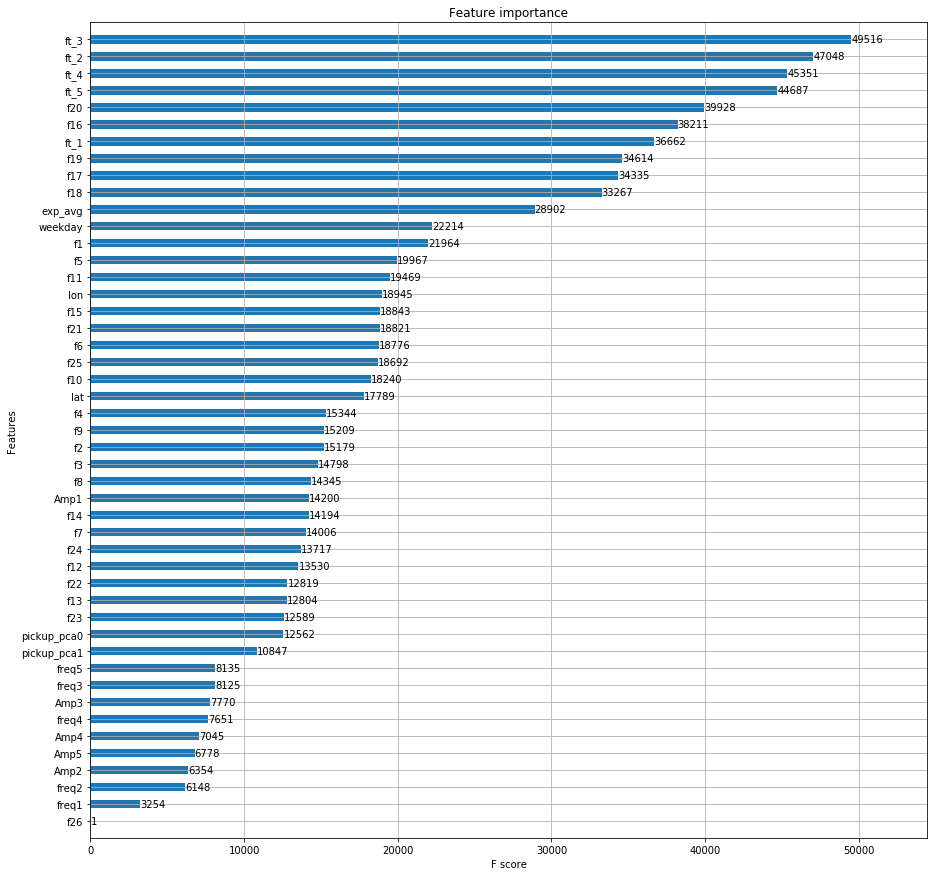

In [154]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height =0.5)
plt.show();plt.close()

# Observation

1. We have loaded the dataset using Dask Dataframe
2. I have perfomred some exploratoty data analysis , on Trip Distance , Speed , Total Fare Longitude Latitude 
   to remove the outlier from the dataset
3 I have performed the Clustering operation to the cluster the whole New York City into different clusters and selected 
  the right cluster size.
4.I have added the feature called Time Binning by converting the Time Data data into Unix TimeSatmps
5. I have performed the smoothing operation beacuse there are some some bins where there is no pick up found
6. I have applied some basline model , Like Simple Moving Average, Weighted Moving Averages, Exponential Weighted averages
   and compare the result
7. Now I have splitted the Dataset into Train and Test(70:30) by taking JAN, FEB, MARCH 2016 Datasets
8. I have performed some feature analysis for our Model
9. I have performed Linear Regression , Random Forest and XGboost model and noted down the Train and Test Result
10. I have performed  Hyperparameter Tunning On Linear Regression , Random Forest and Xgboost using GridSearchCv and RandomSeravhCV
11. I have printed the Train and Test Result
12. I have incorporated some of the time features, Window median,max ,min,Count and first Five Frequency and amplitude 
13. I have run the xgboost model with such features to bring down the loss
